# Shahar Michaeli 
### Imports

In [1]:
import pandas as pd
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Imputer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA 
import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array

In [2]:
df = pd.read_csv('dataFIFA.csv').drop(columns = ['ID','Photo','Unnamed: 0','Club Logo','Flag','Loaned From','Joined','Club'])

In [3]:
# df.info()

# Pandas DataFrame to PySpark DataFrame

In [4]:
# Auxiliar functions
def equivalent_type(f):
    if f == 'datetime64[ns]': return TimestampType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

# Given pandas dataframe, it will return a spark's dataframe.
def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
      struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return sqlContext.createDataFrame(pandas_df, p_schema)

def money_string_replace(variable_name):
    df[variable_name] = (df[variable_name].str[1:].replace(r'[KM]+$', '', regex=True).astype(float) *
                 df[variable_name].str.extract(r'[\d\.]+([KM]+)', expand=False)
                 .fillna(1)
                 .replace(['K','M'], [10**3, 10**6]).astype(int))

In [5]:
# Replace Money Strings to Money Value..
money_string_replace('Value')
money_string_replace('Wage')
money_string_replace('Release Clause')

In [6]:
# Sort the dataframe by Wage column, the top players with the highest wages will be on the top.
df = df.sort_values(by=['Wage'],ascending=False) 

In [7]:
subdf = df[["Overall","Potential","Skill Moves","Position","BallControl","Body Type"]]

In [8]:
spark_df = pandas_to_spark(subdf)
spark_df

DataFrame[Overall: bigint, Potential: bigint, Skill Moves: float, Position: string, BallControl: float, Body Type: string]

In [9]:
spark_df.show()

+-------+---------+-----------+--------+-----------+----------+
|Overall|Potential|Skill Moves|Position|BallControl| Body Type|
+-------+---------+-----------+--------+-----------+----------+
|     94|       94|        4.0|      RF|       96.0|     Messi|
|     91|       91|        3.0|      RS|       90.0|    Normal|
|     91|       91|        4.0|     RCM|       93.0|      Lean|
|     94|       94|        5.0|      ST|       94.0|C. Ronaldo|
|     91|       91|        3.0|     RCB|       84.0|    Normal|
|     90|       90|        3.0|     LCM|       90.0|    Normal|
|     88|       88|        4.0|      ST|       85.0|      Lean|
|     91|       92|        4.0|     RCM|       91.0|    Normal|
|     91|       91|        4.0|      LF|       94.0|    Normal|
|     88|       89|        5.0|      LW|       92.0|    Normal|
|     88|       91|        4.0|      LW|       95.0|    Normal|
|     88|       89|        4.0|     LAM|       90.0|    Normal|
|     89|       89|        3.0|     CDM|

# StringIndexer for Position, Body Type

In [10]:
encoder = StringIndexer(inputCols=["Position","Body Type"],outputCols=["Position1","Body Type1"])
model = encoder.fit(spark_df)
spark_df = model.transform(spark_df)
spark_df.show()

+-------+---------+-----------+--------+-----------+----------+---------+----------+
|Overall|Potential|Skill Moves|Position|BallControl| Body Type|Position1|Body Type1|
+-------+---------+-----------+--------+-----------+----------+---------+----------+
|     94|       94|        4.0|      RF|       96.0|     Messi|     26.0|       7.0|
|     91|       91|        3.0|      RS|       90.0|    Normal|     19.0|       0.0|
|     91|       91|        4.0|     RCM|       93.0|      Lean|     13.0|       1.0|
|     94|       94|        5.0|      ST|       94.0|C. Ronaldo|      0.0|       5.0|
|     91|       91|        3.0|     RCB|       84.0|    Normal|     10.0|       0.0|
|     90|       90|        3.0|     LCM|       90.0|    Normal|     12.0|       0.0|
|     88|       88|        4.0|      ST|       85.0|      Lean|      0.0|       1.0|
|     91|       92|        4.0|     RCM|       91.0|    Normal|     13.0|       0.0|
|     91|       91|        4.0|      LF|       94.0|    Normal|  

In [11]:
spark_df = spark_df.drop("Position","Body Type")
spark_df.show()

+-------+---------+-----------+-----------+---------+----------+
|Overall|Potential|Skill Moves|BallControl|Position1|Body Type1|
+-------+---------+-----------+-----------+---------+----------+
|     94|       94|        4.0|       96.0|     26.0|       7.0|
|     91|       91|        3.0|       90.0|     19.0|       0.0|
|     91|       91|        4.0|       93.0|     13.0|       1.0|
|     94|       94|        5.0|       94.0|      0.0|       5.0|
|     91|       91|        3.0|       84.0|     10.0|       0.0|
|     90|       90|        3.0|       90.0|     12.0|       0.0|
|     88|       88|        4.0|       85.0|      0.0|       1.0|
|     91|       92|        4.0|       91.0|     13.0|       0.0|
|     91|       91|        4.0|       94.0|     27.0|       0.0|
|     88|       89|        5.0|       92.0|     14.0|       0.0|
|     88|       91|        4.0|       95.0|     14.0|       0.0|
|     88|       89|        4.0|       90.0|     24.0|       0.0|
|     89|       89|      

In [12]:
imputer = Imputer(inputCols=spark_df.columns, outputCols=spark_df.columns)
model = imputer.fit(spark_df)

spark_df = model.transform(spark_df)

In [13]:
assemble=VectorAssembler(inputCols=spark_df.columns, outputCol='_features')
assembled_data=assemble.transform(spark_df)
assembled_data.show()

+-------+---------+-----------+-----------+---------+----------+--------------------+
|Overall|Potential|Skill Moves|BallControl|Position1|Body Type1|           _features|
+-------+---------+-----------+-----------+---------+----------+--------------------+
|     94|       94|        4.0|       96.0|     26.0|       7.0|[94.0,94.0,4.0,96...|
|     91|       91|        3.0|       90.0|     19.0|       0.0|[91.0,91.0,3.0,90...|
|     91|       91|        4.0|       93.0|     13.0|       1.0|[91.0,91.0,4.0,93...|
|     94|       94|        5.0|       94.0|      0.0|       5.0|[94.0,94.0,5.0,94...|
|     91|       91|        3.0|       84.0|     10.0|       0.0|[91.0,91.0,3.0,84...|
|     90|       90|        3.0|       90.0|     12.0|       0.0|[90.0,90.0,3.0,90...|
|     88|       88|        4.0|       85.0|      0.0|       1.0|[88.0,88.0,4.0,85...|
|     91|       92|        4.0|       91.0|     13.0|       0.0|[91.0,92.0,4.0,91...|
|     91|       91|        4.0|       94.0|     27.0| 

In [14]:
scale=StandardScaler(inputCol='_features',outputCol='features')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)


In [15]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,50):
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print(f"K = {i}, Silhouette Score :",score)


K = 2, Silhouette Score : 0.4027167796638398
K = 3, Silhouette Score : 0.32667624187198274
K = 4, Silhouette Score : 0.354794212207572
K = 5, Silhouette Score : 0.3404626025352105
K = 6, Silhouette Score : 0.3539988514324568
K = 7, Silhouette Score : 0.3461308065220264
K = 8, Silhouette Score : 0.32146121612863576
K = 9, Silhouette Score : 0.32599883768712473
K = 10, Silhouette Score : 0.3408416410211203
K = 11, Silhouette Score : 0.3025585274542935
K = 12, Silhouette Score : 0.32977083642704474
K = 13, Silhouette Score : 0.32200091043976437
K = 14, Silhouette Score : 0.32933181600623584
K = 15, Silhouette Score : 0.32775204306202216
K = 16, Silhouette Score : 0.33692753845226253
K = 17, Silhouette Score : 0.34793980913736056
K = 18, Silhouette Score : 0.3406183507281656
K = 19, Silhouette Score : 0.3499138373810436
K = 20, Silhouette Score : 0.352137554695319
K = 21, Silhouette Score : 0.34822548313594526
K = 22, Silhouette Score : 0.34737653549000913
K = 23, Silhouette Score : 0.3365

In [16]:
kmeans = KMeans().setK(2)
model = kmeans.fit(data_scale_output)
top_10_df = spark.createDataFrame(data_scale_output.take(10)).drop('_features')
top_10_df.show()

+-------+---------+-----------+-----------+---------+----------+--------------------+
|Overall|Potential|Skill Moves|BallControl|Position1|Body Type1|            features|
+-------+---------+-----------+-----------+---------+----------+--------------------+
|     94|       94|        4.0|       96.0|     26.0|       7.0|[13.6055807890016...|
|     91|       91|        3.0|       90.0|     19.0|       0.0|[13.1713601255229...|
|     91|       91|        4.0|       93.0|     13.0|       1.0|[13.1713601255229...|
|     94|       94|        5.0|       94.0|      0.0|       5.0|[13.6055807890016...|
|     91|       91|        3.0|       84.0|     10.0|       0.0|[13.1713601255229...|
|     90|       90|        3.0|       90.0|     12.0|       0.0|[13.0266199043633...|
|     88|       88|        4.0|       85.0|      0.0|       1.0|[12.7371394620441...|
|     91|       92|        4.0|       91.0|     13.0|       0.0|[13.1713601255229...|
|     91|       91|        4.0|       94.0|     27.0| 

In [17]:
predictions = model.transform(top_10_df)


In [18]:
predictions.groupBy('prediction').count().show()


+----------+-----+
|prediction|count|
+----------+-----+
|         0|   10|
+----------+-----+



# PCA

In [19]:
def reduceByPCA(k,inputCol,outputCol,df):
    pca = PCA(k=k, inputCol=inputCol, outputCol=outputCol)
    model = pca.fit(df)
    transformed = model.transform(df)
    return transformed

def findBestCluster_BySilhoutte(transformed,predictionCol = 'prediction',featuresCol = 'pca_features'):
    max_silhouette,max_silhouette_index = -1,-1
    evaluator = ClusteringEvaluator(predictionCol=predictionCol, featuresCol=featuresCol, \
                                    metricName='silhouette', distanceMeasure='squaredEuclidean')

    for i in range(2,50):
        KMeans_algo=KMeans(featuresCol='features', k=i)

        KMeans_fit=KMeans_algo.fit(transformed)

        output=KMeans_fit.transform(transformed)



        score=evaluator.evaluate(output)

        if max_silhouette < score:
            max_silhouette = score
            max_silhouette_index = i

    print(f"Best Cluster : K = {max_silhouette_index}, Silhouette Score :",max_silhouette)
    return max_silhouette_index

# PCA K = 5

In [20]:
transformed_df = reduceByPCA(k=5,inputCol="features", outputCol="pca_features",df=data_scale_output)
top_10_df = spark.createDataFrame(transformed_df.take(10)).drop('_features','features')

In [21]:
max_silhouette_index = findBestCluster_BySilhoutte(transformed_df)

Best Cluster : K = 2, Silhouette Score : 0.41102935426075193


In [22]:
kmeans = KMeans(featuresCol='pca_features', k=max_silhouette_index)
model = kmeans.fit(transformed_df)
predictions = model.transform(top_10_df)
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   10|
+----------+-----+



## PCA K = 4

In [23]:
transformed_df = reduceByPCA(k=4,inputCol="features", outputCol="pca_features",df=data_scale_output)

In [24]:
top_10_df = spark.createDataFrame(transformed_df.take(10)).drop('_features','features')

In [25]:
max_silhouette_index = findBestCluster_BySilhoutte(transformed_df)

Best Cluster : K = 2, Silhouette Score : 0.43067962835878176


In [26]:
kmeans = KMeans(featuresCol='pca_features', k=max_silhouette_index)

model = kmeans.fit(transformed_df)
predictions = model.transform(top_10_df)
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   10|
+----------+-----+



## PCA K = 3

In [27]:
transformed_df = reduceByPCA(k=3,inputCol="features", outputCol="pca_features",df=data_scale_output)

In [28]:
top_10_df = spark.createDataFrame(transformed_df.take(10)).drop('_features','features')
top_10_df.show()

+-------+---------+-----------+-----------+---------+----------+--------------------+
|Overall|Potential|Skill Moves|BallControl|Position1|Body Type1|        pca_features|
+-------+---------+-----------+-----------+---------+----------+--------------------+
|     94|       94|        4.0|       96.0|     26.0|       7.0|[-20.367483956140...|
|     91|       91|        3.0|       90.0|     19.0|       0.0|[-17.997595777194...|
|     91|       91|        4.0|       93.0|     13.0|       1.0|[-18.537677992799...|
|     94|       94|        5.0|       94.0|      0.0|       5.0|[-19.338387598358...|
|     91|       91|        3.0|       84.0|     10.0|       0.0|[-17.313379914960...|
|     90|       90|        3.0|       90.0|     12.0|       0.0|[-17.478707408504...|
|     88|       88|        4.0|       85.0|      0.0|       1.0|[-17.171106110541...|
|     91|       92|        4.0|       91.0|     13.0|       0.0|[-18.438737833222...|
|     91|       91|        4.0|       94.0|     27.0| 

In [29]:
max_silhouette_index = findBestCluster_BySilhoutte(transformed_df)

Best Cluster : K = 2, Silhouette Score : 0.4768092515264009


In [30]:
kmeans = KMeans(featuresCol='pca_features', k=max_silhouette_index)
model = kmeans.fit(transformed_df)
predictions = model.transform(top_10_df)
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   10|
+----------+-----+



# PCA K = 2

In [31]:
transformed_df = reduceByPCA(k=2,inputCol="features", outputCol="pca_features",df=data_scale_output)
top_10_df = spark.createDataFrame(transformed_df.take(10)).drop('_features','features')

In [32]:
max_silhouette_index = findBestCluster_BySilhoutte(transformed_df)

Best Cluster : K = 2, Silhouette Score : 0.5635439616608435


In [33]:
kmeans = KMeans(featuresCol='pca_features', k=max_silhouette_index)
model = kmeans.fit(transformed_df)
all_data_predictions = model.transform(transformed_df)
top10_predictions = model.transform(top_10_df)


In [34]:
all_data_predictions= all_data_predictions.withColumn("x", vector_to_array("pca_features")[0]).withColumn("y", vector_to_array("pca_features")[1])
top10_predictions= top10_predictions.withColumn("x", vector_to_array("pca_features")[0]).withColumn("y", vector_to_array("pca_features")[1])

alldata_plot_df = all_data_predictions.select('x','y','prediction')
top10_plot_df = top10_predictions.select('x','y','prediction')


In [35]:
d = {}
for i in range(max_silhouette_index):
    d['x'+str(i)] = alldata_plot_df.select('x').where(f'prediction == {i}').collect()
    d['y'+str(i)] = alldata_plot_df.select('y').where(f'prediction == {i}').collect()
    d['x_top10_'+str(i)] = top10_plot_df.select('x').where(f'prediction == {i}').collect()
    d['y_top10_'+str(i)] = top10_plot_df.select('y').where(f'prediction == {i}').collect()

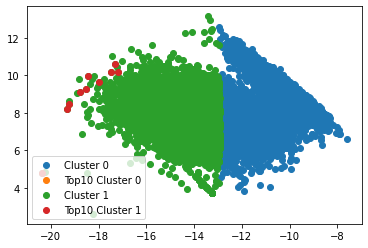

In [36]:
for i in range(max_silhouette_index):
    plt.scatter(d['x'+str(i)],d['y'+str(i)],label = f'Cluster {str(i)}')    
    plt.scatter(d['x_top10_'+str(i)],d['y_top10_'+str(i)],label = f'Top10 Cluster {str(i)}')    

plt.legend()